In [45]:
import pandas as pd 
import numpy as np
import cleaning_functions as cf
import legal_functions as lf
import bail_status_dict as bs

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# feature selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Cross Validation
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

# ML models
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# pipelines
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix


# plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
df_binary = pd.read_csv("../data/clean_merged_df.csv")
df_binary.shape

(3060, 32)

In [47]:
df_large = pd.read_csv("../data/very_large_df.csv")
df_large.shape

(3060, 137)

In [48]:
# clean_incustody rather than encode_incustody
# dropping rows witgh unknown custodial status
df_binary = cf.clean_incustody(df_binary)
df_large = cf.clean_incustody(df_large)

127 rows have been dropped
127 rows have been dropped


In [49]:
df_binary = df_binary.drop(columns = ['Unnamed: 0', 'Offence Location', 'Date', 'Proceeding Type', 'Offence Number', 'Offence'])
df_large = df_large.drop(columns = ['Unnamed: 0', 'Offence Location', 'Date', 'Proceeding Type', 'Offence Number', 'Offence'])
df_binary.dtypes

Release Type                   float64
In Custody                       int64
Days in Court                    int64
Court                            int64
Election                         int64
Discharge Available              int64
SS Available                     int64
CSO Available                    int64
Maximum (Summary)(Years)         int64
Maximum (Indictable)(Years)      int64
Has Lawyer                       int64
Abbotsford                       int64
New Westminster                  int64
North Vancouver                  int64
Port Coquitlam                   int64
Richmond                         int64
Surrey                           int64
Vancouver                        int64
Victoria                         int64
Offence_0                        int64
Offence_1                        int64
Offence_2                        int64
Offence_3                        int64
Offence_4                        int64
Offence_5                        int64
Offence_6                

### Run train-test split and XG boost on Binary-encoded df first

In [50]:
# Split the data into features (X) and target (y)
X = df_binary.drop('In Custody', axis=1)
y = df_binary['In Custody']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Fit the XGBoost model
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test data
y_pred = xgb_model.predict(X_test)

# Calculate accuracy, precision, recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# print results
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.888
Precision: 0.829
Recall: 0.709


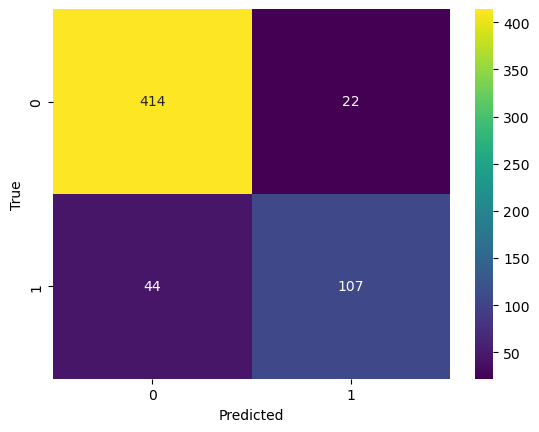

In [52]:
# Calculate the confusion matrix
confused = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
sns.heatmap(confused, annot = True, fmt = 'd', cmap = 'viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

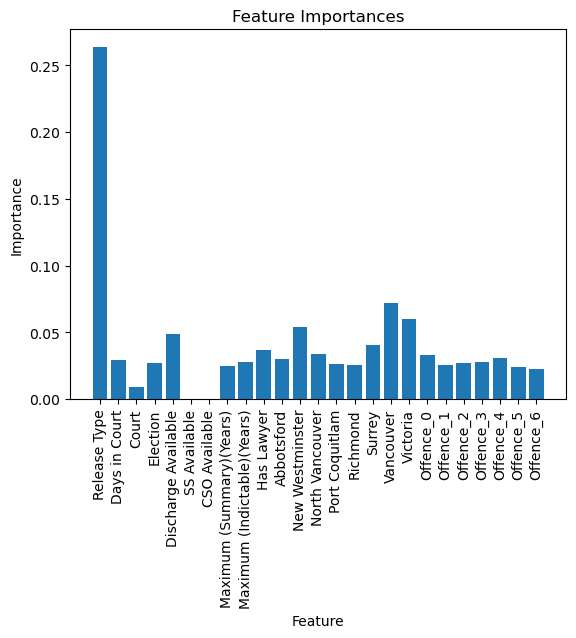

In [53]:
# Plot the feature importances
plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
plt.xticks(range(len(xgb_model.feature_importances_)), X_train.columns, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

In [54]:
# great results, but it's because of the release type column! Clearly there is overlap between this 
# info and the bail status
# drop the column and re-run

In [81]:
# Split the data into features (X) and target (y), and drop release type
X = df_binary.drop(columns = ['In Custody', 'Release Type'], axis=1)
y = df_binary['In Custody']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
# Fit the XGBoost model
xgb_model = XGBClassifier(n_estimators = 100, random_state = 42)
xgb_model.fit(X_train, y_train)

# Predict on the test data
y_pred = xgb_model.predict(X_test)

# Calculate accuracy, precision, recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# print results
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.806
Precision: 0.683
Recall: 0.457


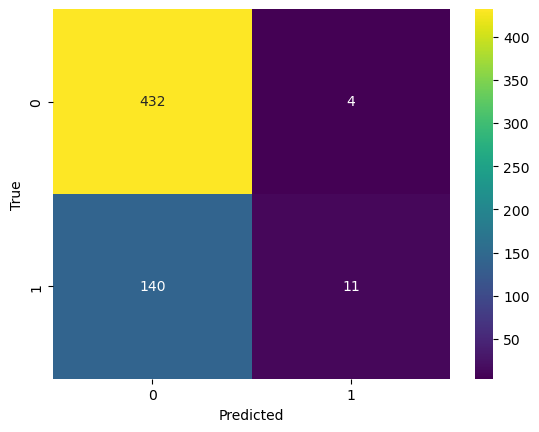

In [89]:
# Calculate the confusion matrix
confused = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
sns.heatmap(confused, annot = True, fmt = 'd', cmap = 'viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

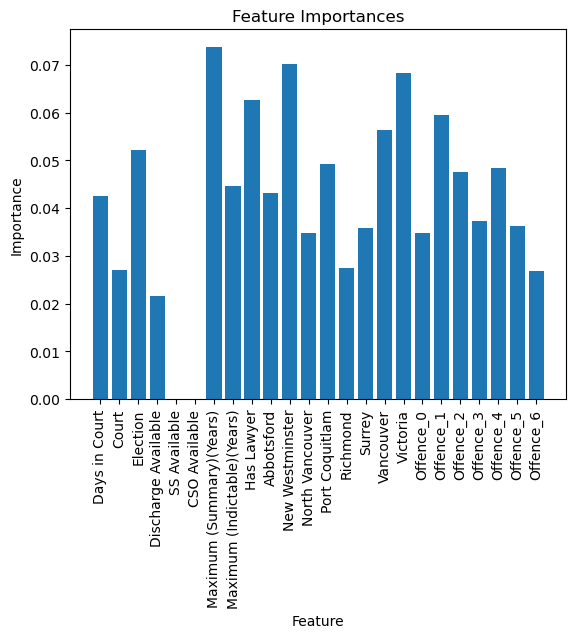

In [84]:
# Plot the feature importances
plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
plt.xticks(range(len(xgb_model.feature_importances_)), X_train.columns, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

GridSearch to get optimal parameters 
* apparently it's better to do this with cross-validation rather than train-test split, in order to avoid overfitting

In [58]:
# recall that X = df_binary.drop(columns = ['In Custody', 'Release Type'], axis=1)
            # y = df_binary['In Custody']

# instantiate XGB 
xgb = XGBClassifier()

# define the hyperparameter grid to search over
param_grid = {  'n_estimators' : [20, 30, 40],
                'learning_rate': [0.01, 0.03, 0.04],
                'max_depth': [6, 7, 8],
                'subsample': [0.3, 0.5, 0.7],
                'colsample_bytree': [0.3, 0.5, 0.7]
              }

grid_search = GridSearchCV(xgb, param_grid, cv=10)
grid_search.fit(X, y)

print('Best hyperparameters:', grid_search.best_params_)
print('Cross-validation score:', grid_search.best_score_)

Best hyperparameters: {'colsample_bytree': 0.5, 'learning_rate': 0.04, 'max_depth': 7, 'n_estimators': 30, 'subsample': 0.3}
Cross-validation score: 0.7742994125978037


Run prediction model with best params

In [88]:
# initialize a XGB model with optimal params
xgb_model_final = XGBClassifier(n_estimators = 30, 
                    colsample_bytree = 0.5, 
                    learning_rate = 0.03, 
                    max_depth = 7, 
                    subsample = 0.5,
                    random_state = 42)

xgb_model_final.fit(X_train, y_train)

# Predict on the test data
y_pred = xgb_model_final.predict(X_test)

# Calculate accuracy, precision, recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# print results
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.755
Precision: 0.733
Recall: 0.073


Previous results:
Accuracy: 0.806
Precision: 0.683
Recall: 0.457

Accuracy is down, precision is up, recall is way lower (why?)

### See if XGB works any better with one-hot encoded (large) df

In [60]:
# Split the data into features (X) and target (y), and drop release type
X = df_large.drop(columns = ['In Custody', 'Release Type'], axis=1)
y = df_large['In Custody']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
# Fit the XGBoost model
xgb_model = XGBClassifier(n_estimators = 100, random_state = 42)
xgb_model.fit(X_train, y_train)

# Predict on the test data
y_pred = xgb_model.predict(X_test)

# Calculate accuracy, precision, recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# print results
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.802
Precision: 0.664
Recall: 0.470


Previous results:
Previous results:
Accuracy: 0.806
Precision: 0.683
Recall: 0.457

About the same, really

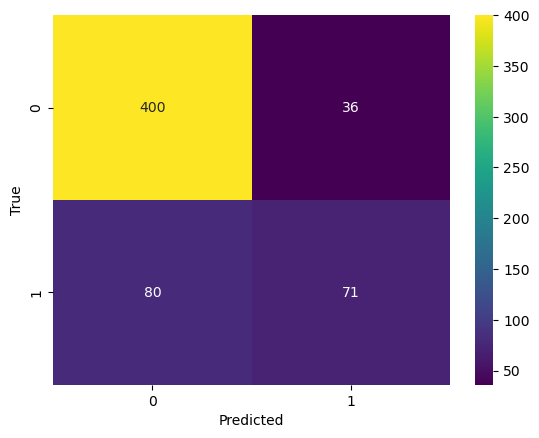

In [62]:
# Calculate the confusion matrix
confused = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
sns.heatmap(confused, annot = True, fmt = 'd', cmap = 'viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

GridSearch to tune parameters

In [63]:
'''# recall that X = df_large.drop(columns = ['In Custody', 'Release Type'], axis=1)
            # y = df_large['In Custody']

# instantiate XGB 
xgb = XGBClassifier()

# define the hyperparameter grid to search over
param_grid = {  'n_estimators' : [20, 30, 40, 50],
                'learning_rate': [0.01, 0.03, 0.04],
                'max_depth': [6, 7, 8],
                'subsample': [0.3, 0.5, 0.7],
                'colsample_bytree': [0.3, 0.5, 0.7]
              }

grid_search = GridSearchCV(xgb, param_grid, cv=10)
grid_search.fit(X, y)

print('Best hyperparameters:', grid_search.best_params_)
print('Cross-validation score:', grid_search.best_score_)
'''

"# recall that X = df_large.drop(columns = ['In Custody', 'Release Type'], axis=1)\n            # y = df_large['In Custody']\n\n# instantiate XGB \nxgb = XGBClassifier()\n\n# define the hyperparameter grid to search over\nparam_grid = {  'n_estimators' : [20, 30, 40, 50],\n                'learning_rate': [0.01, 0.03, 0.04],\n                'max_depth': [6, 7, 8],\n                'subsample': [0.3, 0.5, 0.7],\n                'colsample_bytree': [0.3, 0.5, 0.7]\n              }\n\ngrid_search = GridSearchCV(xgb, param_grid, cv=10)\ngrid_search.fit(X, y)\n\nprint('Best hyperparameters:', grid_search.best_params_)\nprint('Cross-validation score:', grid_search.best_score_)\n"

Run model with best hyperparameters

In [64]:
xgb_model_final = XGBClassifier(colsample_bytree = 0.5, 
                    learning_rate = 0.04, 
                    max_depth = 6, 
                    n_estimators = 50, 
                    subsample = 0.7)

# fit the model
xgb_model_final.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [65]:
importance_dict = xgb_model_final.get_booster().get_score(importance_type='weight')
importance_dict = {k: v for k, v in sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)}

top_k = 10
top_k_features = dict(list(importance_dict.items())[:top_k])
print(top_k_features)

{'Days in Court': 394.0, 'Maximum (Indictable)(Years)': 69.0, 'Has Lawyer': 52.0, 'Election': 39.0, 'Vancouver': 39.0, 'Assault': 39.0, 'Abbotsford': 37.0, 'Surrey': 37.0, 'Break and enter with intent (not dwelling)': 35.0, 'Port Coquitlam': 29.0}


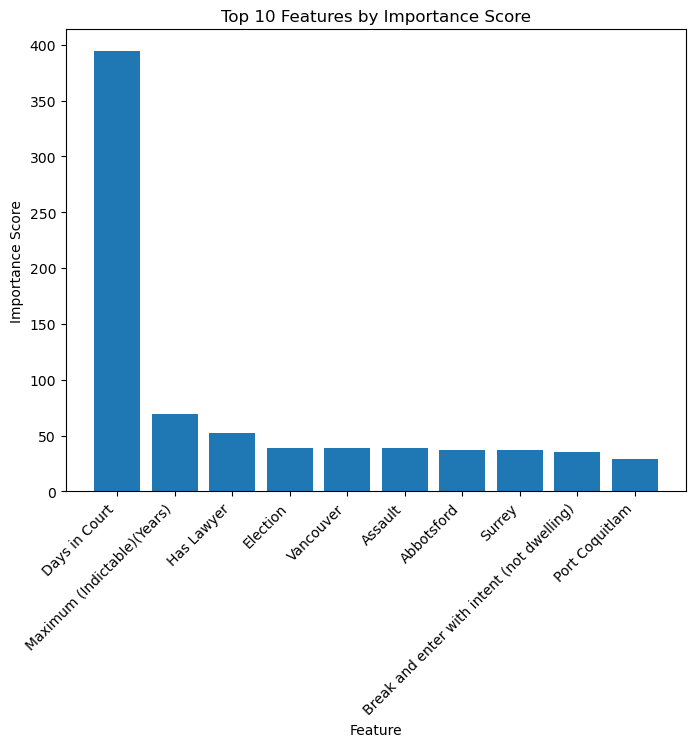

In [66]:
# Sort the feature importances in descending order
sorted_importances = sorted(top_k_features.items(), key=lambda x:x[1], reverse=True)

# Extract the feature names and importance scores into separate lists
features = [f[0] for f in sorted_importances]
scores = [f[1] for f in sorted_importances]

# Create a vertical bar chart
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(features, scores)

# Set chart title and axis labels
ax.set_title("Top 10 Features by Importance Score")
ax.set_xlabel("Feature")
ax.set_ylabel("Importance Score")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

### KNN for Offence Types (using Cross Validation rather than train-test split)

First on the binary-encoded dataset

In [67]:
# Split the data into features (X) and target (y)
X = df_binary.drop(['In Custody', 'Release Type'], axis=1)
y = df_binary['In Custody']

# instantiate KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# train the model on the binary encoded df
knn.fit(X, y)

KNeighborsClassifier()

In [68]:
# perform 10-fold cross-validation
scores = cross_val_score(knn, X, y, cv = 10)

# print the mean and standard deviation of the scores
print('Mean accuracy of 10-fold cross validation: {:.2f}  STD of those means: {:.2f}'.format(scores.mean(), scores.std()))

c:\Users\emily\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\emily\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Mean accuracy of 10-fold cross validation: 0.73  STD of those means: 0.03


c:\Users\emily\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\emily\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

KNN Using GridSearch to Tune Parameters

In [69]:
# train a KNN classifier on the encoded 'Offence Type' column
knn2 = KNeighborsClassifier()
knn2.fit(X, y)

KNeighborsClassifier()

In [70]:
# define the hyperparameter grid to search over
param_grid = {'n_neighbors': [26, 27, 28, 29],
              'weights' : ['uniform', 'distance'],
              'p' : [1, 2, float('inf')]
              }

# create a GridSearchCV object with 10-fold cross validation
grid_search = GridSearchCV(knn2, param_grid, cv = 10)

In [71]:
# fit the grid search to the data
grid_search.fit(X, y)

# print the best hyperparameters and cross-validation score
print('Best hyperparameters:', grid_search.best_params_)
print('Cross-validation score:', grid_search.best_score_)

c:\Users\emily\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\emily\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Best hyperparameters: {'n_neighbors': 27, 'p': 1, 'weights': 'distance'}
Cross-validation score: 0.7667932019224072


In [72]:
# initialize a KNN model with optimal params (p = 2 and weights = uniform are default)
knn3 = KNeighborsClassifier(n_neighbors = 26)

# perform 10-fold cross-validation and get the predicted class labels
y_pred = cross_val_predict(knn3, X, y, cv = 10)

# compute the almagamated confusion matrix for the 10 tests
confused = confusion_matrix(y, y_pred)
print(confused)

c:\Users\emily\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\emily\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[[2150   52]
 [ 660   71]]


c:\Users\emily\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


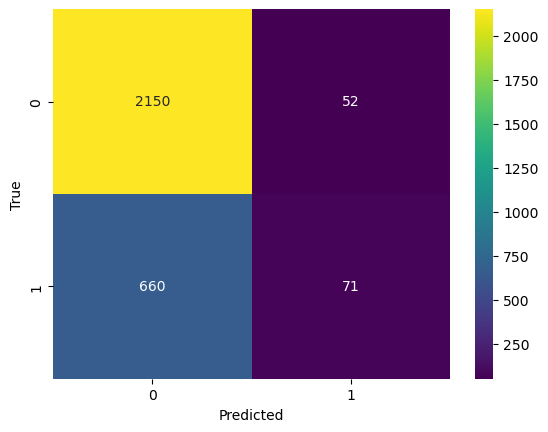

In [73]:
# Plot the confusion matrix using seaborn
sns.heatmap(confused, annot=True, fmt='d', cmap = 'viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Now do KNN the large_df

In [74]:
# Split the data into features (X) and target (y)
X = df_large.drop(['In Custody', 'Release Type'], axis=1)
y = df_large['In Custody']

# instantiate KNN classifier
knn3 = KNeighborsClassifier()

# train the model on the binary encoded df
knn3.fit(X, y)


# define the hyperparameter grid to search over
param_grid = {'n_neighbors': [5, 10, 15, 25, ],
              'weights' : ['uniform', 'distance'],
              'p' : [1, 2, float('inf')]
              }

# create a GridSearchCV object with 10-fold cross validation
grid_search = GridSearchCV(knn3, param_grid, cv=10)


# fit the grid search to the data
grid_search.fit(X, y)

# print the mean and standard deviation of the scores
print('Mean accuracy of 10-fold cross validation: {:.2f}  STD of those means: {:.2f}'.format(scores.mean(), scores.std()))

# print the best hyperparameters and cross-validation score
print('Best hyperparameters:', grid_search.best_params_)
print('Cross-validation score:', grid_search.best_score_)

c:\Users\emily\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\emily\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Mean accuracy of 10-fold cross validation: 0.73  STD of those means: 0.03
Best hyperparameters: {'n_neighbors': 25, 'p': 1, 'weights': 'distance'}
Cross-validation score: 0.7627011214041931


### Naive Bayes
Using 10-fold cross validation rather than train-test split, due to volume of data / risk of overfitting